Exploration: How does footprint manifest itself in a stack of 2D spectra?

In [337]:
import numpy as np
import scipy as sp
from scipy import ndimage as ndi
from numpy.fft import fft2, ifft2, fftshift, ifftshift, fftn

from skimage import io
from skimage.util import img_as_float
# from skimage.filters import gaussian
from scipy.ndimage import gaussian_filter, uniform_filter, label
from skimage.color import rgb2gray, label2rgb
from skimage.feature import peak_local_max, canny
from skimage.restoration import denoise_tv_chambolle
from skimage.draw import  circle
import skimage.morphology as morph
from skimage.measure import label, compare_ssim
import skimage.exposure as skie
from astropy.convolution import convolve, Gaussian2DKernel
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, interact_manual, FloatSlider, IntSlider, fixed
import ipywidgets as widgets
from IPython.display import display
import matplotlib.patches as patches

Load example dataset I'm familiar with (F3):

In [2]:
#The data file used for algo development
devfile = "../images_and_data/F3_original_subvolume_IL230-430_XL475-675_T200-1800.npy"

#Load it
data = np.load(devfile)

print("Data shape:" + str(data.shape))

Data shape:(201, 201, 401)


Have a gander at the data:

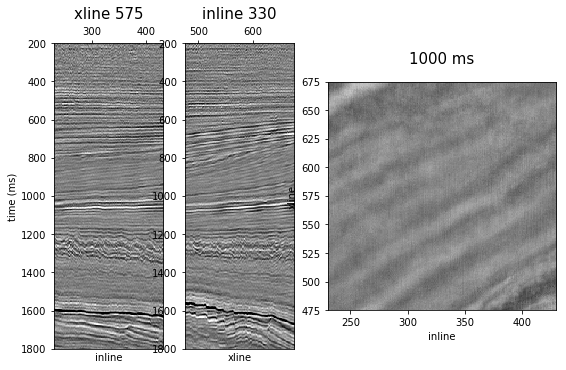

In [272]:
# find 99th percentile of amplitude for plot scaling
plotamp = np.percentile(data, 99.9)

# Plot the 3D data
atts = plt.figure(figsize=(9,6))

# Look at XL index 100
ax1 = atts.add_subplot(141)
ax1.imshow(data[:,100,:1000].T,extent=(230,430,1800,200), cmap="gray",vmin=-plotamp, vmax=plotamp, aspect='0.35')
ax1.xaxis.tick_top()
plt.text(0.5, 1.08, 'xline 575', fontsize=15,horizontalalignment='center',transform = ax1.transAxes)
ax1.set_xlabel('inline')
ax1.set_ylabel('time (ms)')
#ax1.axes.get_yaxis().set_ticks(times[::50])

# Look at IL index 100
ax1 = atts.add_subplot(142)
ax1.imshow(data[100,:,:1000].T,extent=(475,675,1800,200), cmap="gray",vmin=-plotamp, vmax=plotamp, aspect='0.35')
ax1.xaxis.tick_top()
plt.text(0.5, 1.08, 'inline 330', fontsize=15,horizontalalignment='center',transform = ax1.transAxes)
ax1.set_xlabel('xline')
#ax1.set_ylabel('time (ms)')
#ax1.axes.get_yaxis().set_ticks([])

# Look at T index 100
ax1 = atts.add_subplot(122)
ax1.imshow(data[:,:,175].T, extent=(230, 430, 475, 675), cmap="gray",vmin=-plotamp, vmax=plotamp, aspect='1') # I didn't plot the Transpose here
plt.text(0.5, 1.08, '1000 ms', fontsize=15,horizontalalignment='center',transform = ax1.transAxes)
ax1.set_xlabel('inline')
ax1.set_ylabel('xline');

Calculate a stack of 2D spectra and confirm shape

In [282]:
FS = np.zeros_like(data)

for i in range(data.shape[-1]):
    FS[:,:,i] = np.abs(fftshift(fft2(data[:,:,i])))

FS_filt = gaussian_filter(FS, [0,0,20])
    
FS.shape

(201, 201, 401)

Write a little plotting function:

In [82]:
def plot_spectra(spec, XL, IL, T):
    atts = plt.figure(figsize=(18,12))

    # Look at "XL" index 50
    ax1 = atts.add_subplot(141)
    ax1.imshow(spec[:,XL,:].T, cmap="gray")
    ax1.axhline(T, color='red')
    ax1.axvline(IL, color='red')

    # Look at "IL" index 50
    ax1 = atts.add_subplot(142)
    ax1.imshow(spec[IL,:,:].T, cmap="gray")
    ax1.axhline(T, color='red')
    ax1.axvline(XL, color='red')

    # Look at "T" index 150
    ax1 = atts.add_subplot(122)
    ax1.imshow(spec[:,:,T].T, cmap="gray")
    ax1.axhline(XL, color='red')
    ax1.axvline(IL, color='red');

Now look at the spectra stack:

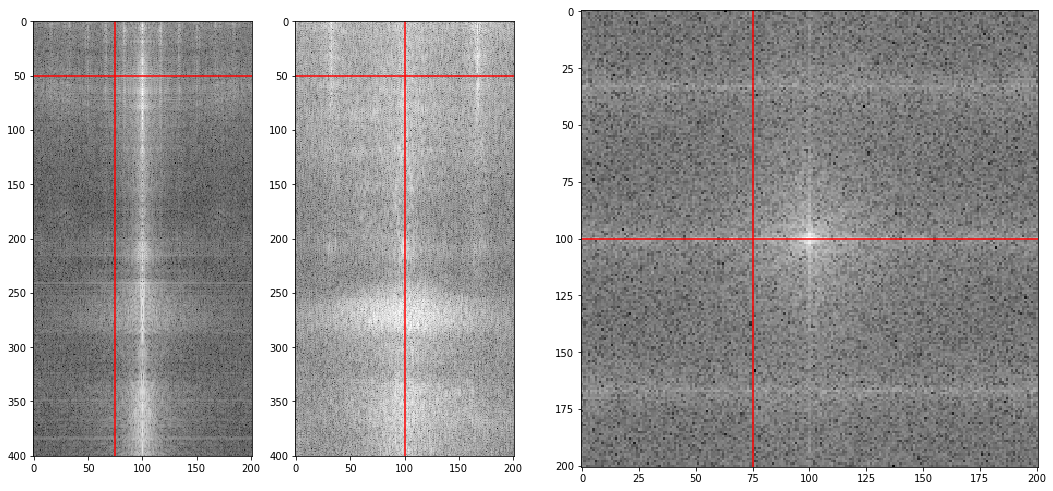

In [92]:
plot_spectra(FS, 100, 75, 50)

And the filtered version that enhances the footprint:

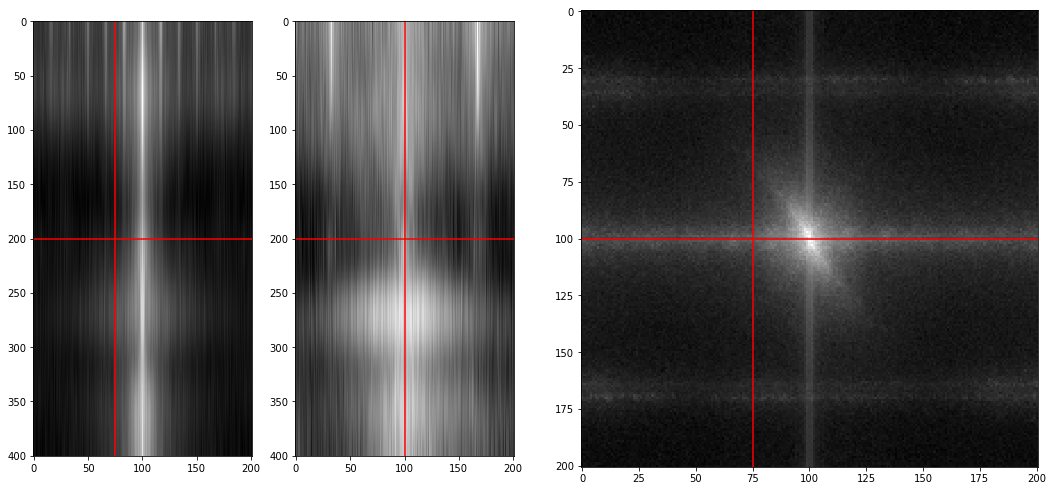

In [284]:
plot_spectra(np.log(FS_filt), 100,75,200)

What's with the two horizontal bands on the time slice (~30 and 170)? They're long-lived and relatively strong. Can I move them by changing shape or size of analyzed volume?

In [114]:
sub01 = data[-100:,-100:,:100]

FS_sub01 = np.zeros_like(sub01)

for i in range(sub01.shape[-1]):
    FS_sub01[:,:,i] = np.log(np.abs(fftshift(fft2(sub01[:,:,i]))))

FS_sub01_filt = gaussian_filter(FS_sub01, [0,0,10])
    
FS_sub01.shape

(100, 100, 100)

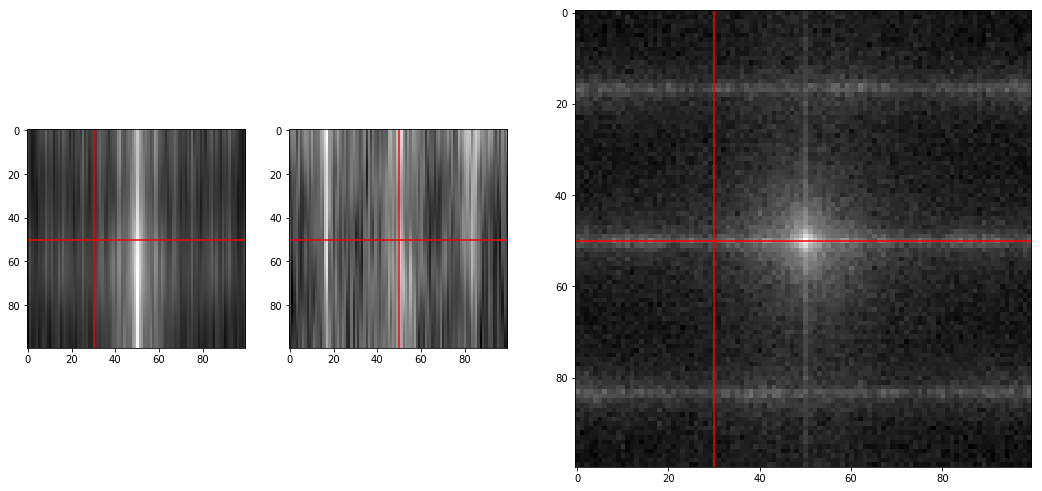

In [115]:
plot_spectra(FS_sub01_filt, 50,30,50)

Those bands are resilient... they are present no matter what I do to the shape or size of the volume.

I'll create a filter for them. The inverse of that filter will give a clue about what they are. Applying that filter to the data will demonstrate what difference it makes to the data.

ALSO, I'll use padding.

In [156]:
# mycarta's padding functions

def im_pad(im):
    out = np.zeros([3*im.shape[0],3*im.shape[1]])
    out[im.shape[0]:2*im.shape[0],im.shape[1]:2*im.shape[1]]=im
    return out

def im_unpad(im):
    out = im[im.shape[0]//3:2*im.shape[0]//3,im.shape[1]//3:2*im.shape[1]//3]
    return out

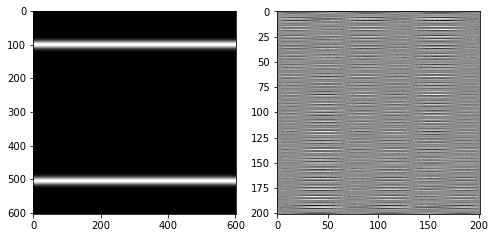

In [266]:
band_filt = np.zeros_like(im_pad(FS[:,:,0]))

target_band = 99

band_filt[:,target_band] = 1
band_filt[:,-target_band] = 1

band_filt = gaussian_filter(band_filt, 8)

band_filt_inv = im_unpad(ifft2(ifftshift(band_filt)).real)

atts = plt.figure(figsize=(8,8))
ax1 = atts.add_subplot(121)
ax1.imshow(band_filt.T, cmap='gray')
ax2 = atts.add_subplot(122)
ax2.imshow(band_filt_inv[:,:].T, cmap='gray')

Let's try applying this filter to the data to see how effective it is.

In [261]:
np.max(band_filt)

0.04987017897166088

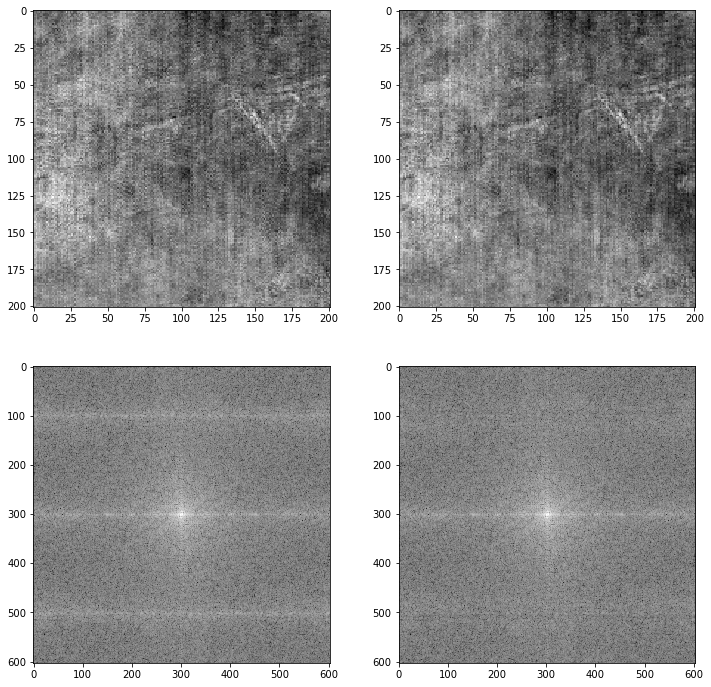

In [263]:
filter_strength = 0.5

time_slice = data[:,:,50]
time_slice_FS = fft2(im_pad(time_slice))

filtered_FS = np.multiply(1 - (filter_strength * (ifftshift(band_filt) / np.max(band_filt))),
                          time_slice_FS)

time_slice_filtered = im_unpad(np.real(ifft2(filtered_FS)))

atts = plt.figure(figsize=(12,12))
ax1 = atts.add_subplot(221)
ax1.imshow(time_slice.T, cmap='gray')
ax2 = atts.add_subplot(222)
ax2.imshow(time_slice_filtered.T, cmap='gray')
ax3 = atts.add_subplot(223)
ax3.imshow(np.log(np.abs(fftshift(time_slice_FS))).T, cmap='gray')
ax4 = atts.add_subplot(224)
ax4.imshow(fftshift(np.log(np.abs(filtered_FS))).T, cmap='gray');

Show the difference:

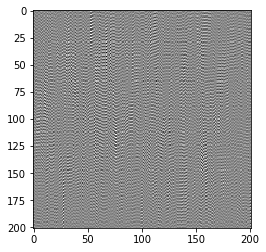

In [265]:
plt.imshow((time_slice - time_slice_filtered).T, cmap='gray')

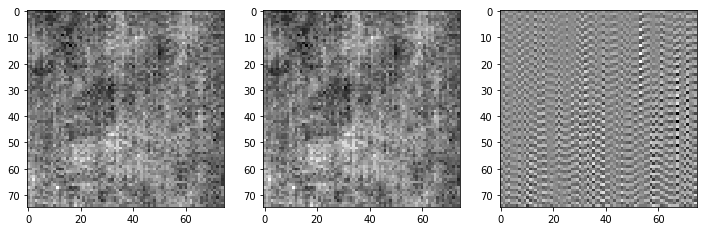

In [281]:
# Close up!

atts = plt.figure(figsize=(12,12))
ax1 = atts.add_subplot(131)
ax1.imshow(time_slice[:75,:75].T, cmap='gray')
ax2 = atts.add_subplot(132)
ax2.imshow(time_slice_filtered[:75,:75].T, cmap='gray')
ax3 = atts.add_subplot(133)
ax3.imshow((time_slice - time_slice_filtered)[:75,:75].T, cmap='gray')

It's tidied up a bit. Still more to do though!

### "Automatic" Segmentation

Could we automatically segment the spectra stack? If so, we could drop the central segment (the one containing the geological info) and then convolve the rest with a kernel or something.

The core segment might be best discovered by binary segmentation. That could then be held separately.

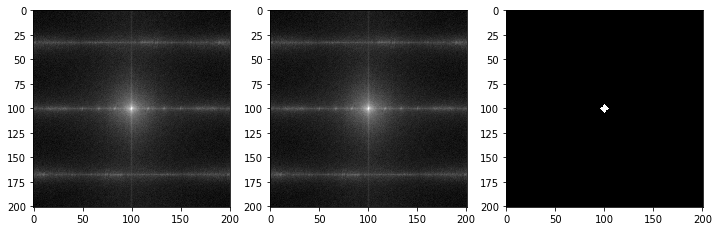

In [322]:
# Start with the filtered FS

# Square the amplitudes:
FS_filt_sq = np.power(FS_filt, 2)

# # Apply a threshold:
# thresh = 1e11
# FS_filt_sq_thresh = np.copy(FS_filt_sq) # create a copy
# thresh_idx = FS_filt_sq_thresh < thresh # find indicies less than threshold
# FS_filt_sq_thresh[thresh_idx] = 0 # set those entries to zero

binary = np.zeros(FS_filt.shape, dtype=np.uint8)
binary[FS_filt_sq > 8e12] = 1

atts = plt.figure(figsize=(12,12))
ax1 = atts.add_subplot(131)
ax1.imshow(np.log(FS_filt)[:,:,50].T, cmap='gray')
ax2 = atts.add_subplot(132)
ax2.imshow(np.log(FS_filt_sq)[:,:,50].T, cmap='gray')
# ax3 = atts.add_subplot(133)
# ax3.imshow(np.log(FS_filt_sq_thresh[:,:,50]+0.001).T, cmap='gray')
ax3 = atts.add_subplot(133)
ax3.imshow(np.log(binary[:,:,50]+0.001).T, cmap='gray')

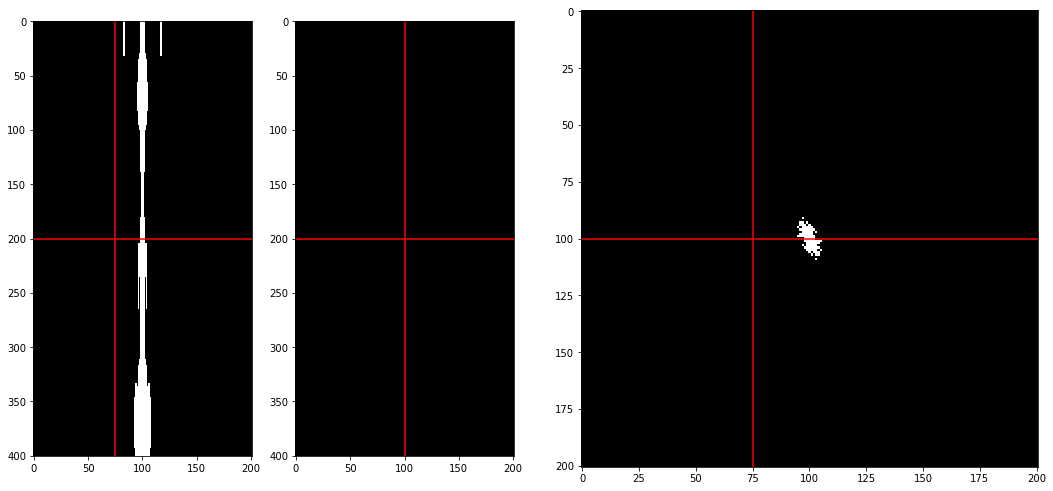

In [323]:
plot_spectra(binary, 100,75,200)

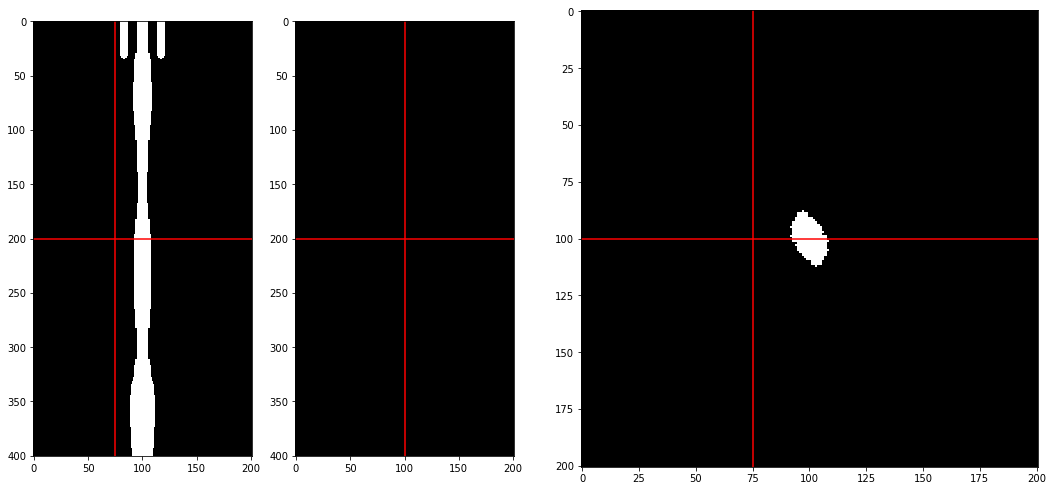

In [344]:
binary_dilated_bool = morph.binary_dilation(binary, selem=morph.ball(3))

binary_dilated = np.zeros(FS_filt.shape, dtype=np.uint8)
binary_dilated[binary_dilated_bool] = 1

plot_spectra(binary_dilated, 100,75,200)

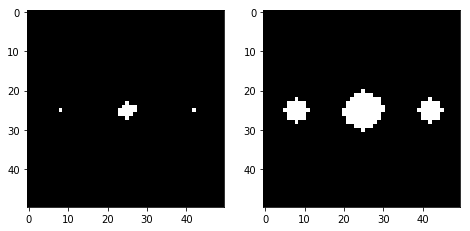

In [345]:
atts = plt.figure(figsize=(12,12))
ax1 = atts.add_subplot(131)
ax1.imshow(binary[75:125,75:125,10].T, cmap='gray')
ax2 = atts.add_subplot(132)
ax2.imshow(binary_dilated[75:125,75:125,10].T, cmap='gray')
# ax3 = atts.add_subplot(133)
# ax3.imshow(np.log(FS_filt_sq_thresh[:,:,50]+0.001).T, cmap='gray')
# ax3 = atts.add_subplot(133)
# ax3.imshow(np.log(binary[:,:,50]+0.001).T, cmap='gray')

Identify the largest element and keep it. Discard the rest.

In [389]:
label_objects = label(binary_dilated) # label discrete bodies
sizes = np.bincount(label_objects.ravel()) # calculate sizes
sizes[0] = 0 # first body is background... set volume to zero
mask_sizes = sizes == np.max(sizes) # find largest remaining body - should be core
cleaned = mask_sizes[label_objects]*1. # Leave only core

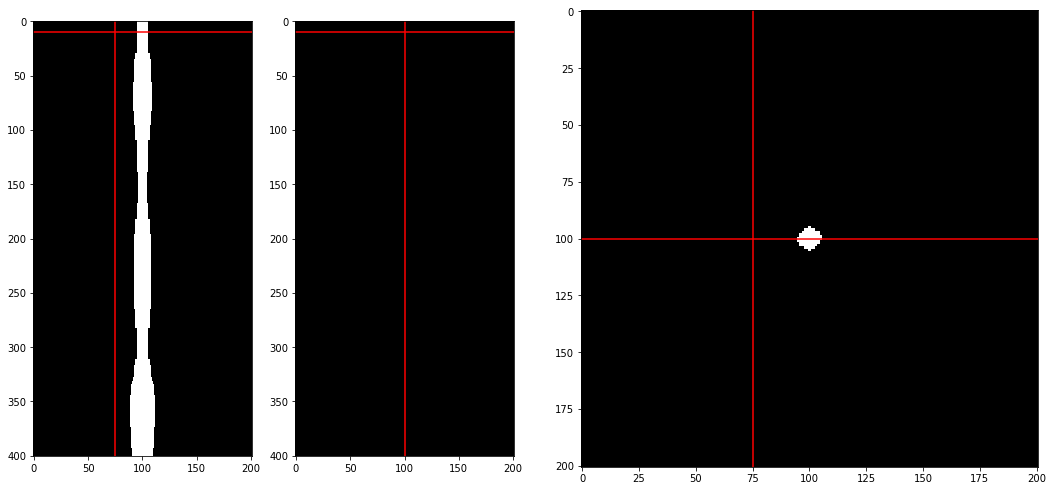

In [390]:
plot_spectra(cleaned, 100,75,10)

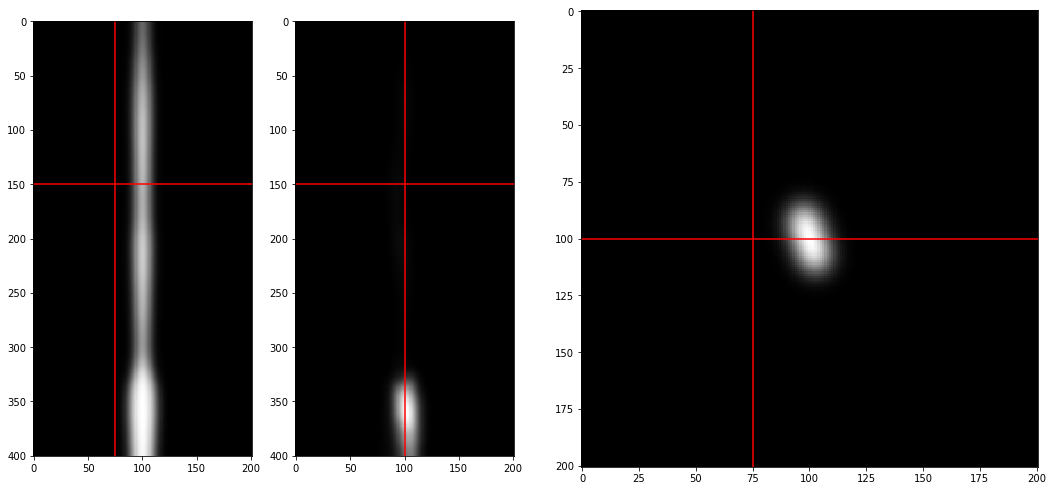

In [396]:
# Colvolve with gaussian filter

core_filter_FS = gaussian_filter(cleaned, [5,5,5])

plot_spectra(core_filter_FS, 100,75,150)

Now, apply this filter to the original spectra:

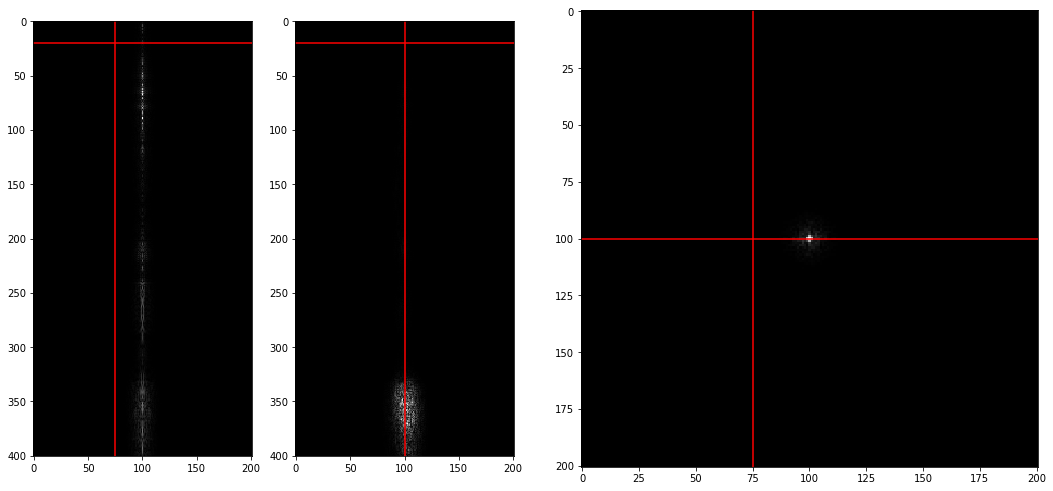

In [400]:
core_filtered_FS = core_filter_FS * FS

plot_spectra(core_filtered_FS, 100,75,20)

Now I need to ifftshift each slice and then ifft2 each as well.

In [401]:
data_core_filt = np.zeros_like(data)

for i in range(data.shape[-1]):
    data_core_filt[:,:,i] = np.real(ifft2(ifftshift(core_filtered_FS[:,:,i])))

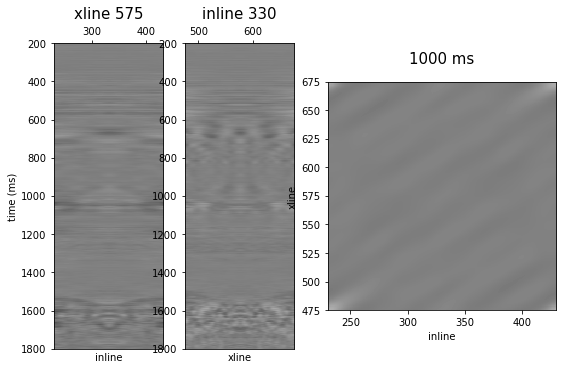

In [402]:
# find 99th percentile of amplitude for plot scaling
plotamp = np.percentile(data_core_filt, 99.9)

# Plot the 3D data
atts = plt.figure(figsize=(9,6))

# Look at XL index 100
ax1 = atts.add_subplot(141)
ax1.imshow(data_core_filt[:,100,:1000].T,extent=(230,430,1800,200), cmap="gray",vmin=-plotamp, vmax=plotamp, aspect='0.35')
ax1.xaxis.tick_top()
plt.text(0.5, 1.08, 'xline 575', fontsize=15,horizontalalignment='center',transform = ax1.transAxes)
ax1.set_xlabel('inline')
ax1.set_ylabel('time (ms)')
#ax1.axes.get_yaxis().set_ticks(times[::50])

# Look at IL index 100
ax1 = atts.add_subplot(142)
ax1.imshow(data_core_filt[100,:,:1000].T,extent=(475,675,1800,200), cmap="gray",vmin=-plotamp, vmax=plotamp, aspect='0.35')
ax1.xaxis.tick_top()
plt.text(0.5, 1.08, 'inline 330', fontsize=15,horizontalalignment='center',transform = ax1.transAxes)
ax1.set_xlabel('xline')
#ax1.set_ylabel('time (ms)')
#ax1.axes.get_yaxis().set_ticks([])

# Look at T index 100
ax1 = atts.add_subplot(122)
ax1.imshow(data_core_filt[:,:,175].T, extent=(230, 430, 475, 675), cmap="gray",vmin=-plotamp, vmax=plotamp, aspect='1') # I didn't plot the Transpose here
plt.text(0.5, 1.08, '1000 ms', fontsize=15,horizontalalignment='center',transform = ax1.transAxes)
ax1.set_xlabel('inline')
ax1.set_ylabel('xline');

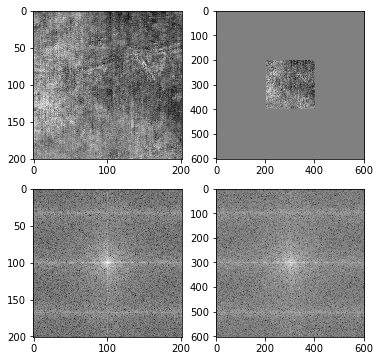

In [166]:
time_slice = data[:,:,50]
time_slice_pad = im_pad(time_slice)

time_slice_FS = np.log(np.abs(fftshift(fft2(time_slice))))
time_slice_pad_FS = np.log(np.abs(fftshift(fft2(time_slice_pad))))

atts = plt.figure(figsize=(6,6))
ax1 = atts.add_subplot(221)
ax1.imshow(time_slice.T, cmap='gray')
ax2 = atts.add_subplot(222)
ax2.imshow(time_slice_pad.T, cmap='gray')
ax3 = atts.add_subplot(223)
ax3.imshow(time_slice_FS.T, cmap='gray')
ax4 = atts.add_subplot(224)
ax4.imshow(time_slice_pad_FS.T, cmap='gray');

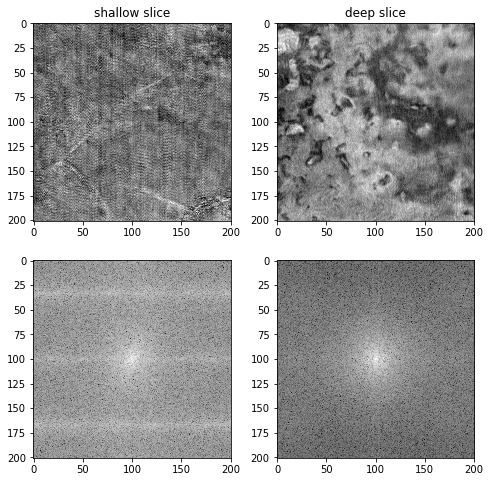

In [94]:
FSslice_shallow = fft2(data[:,:,25]) 
FSslice_deep = fft2(data[:,:,250])

# Create a real version for visualization
FSslice_shallow_real = np.log(np.abs(fftshift(FSslice_shallow)))
FSslice_deep_real = np.log(np.abs(fftshift(FSslice_deep)))

atts = plt.figure(figsize=(8,8))
ax1 = atts.add_subplot(221)
ax1.imshow(data[:,:,25].T, cmap='gray')
ax3 = atts.add_subplot(223)
ax3.imshow(FSslice_shallow_real.T, cmap='gray')
ax1.set_title('shallow slice')
ax2 = atts.add_subplot(222)
ax2.imshow(data[:,:,250].T, cmap='gray')
ax4 = atts.add_subplot(224)
ax4.imshow(FSslice_deep_real.T, cmap='gray')
ax2.set_title('deep slice');

Ah! The grid pattern seen _is_ the footprint. However, the footprint is seen most strongly for shallow time.